# LIGHT-GBM - RETAIL DEMAND PREDICTION

We will tune these following hyperparameters
* **n_estimators:** The number of boosting rounds (trees) to build. Increasing this can lead to better performance but also increases training time.
* **num_leaves:** The maximum number of leaves in one tree. This parameter controls the complexity of the trees. Increasing it may lead to overfitting, while decreasing it may lead to underfitting.
* **min_child_samples:** Specifies the minimum number of training data points required to create a new leaf in the decision tree.
* **subsample:** A floating-point value typically ranging from 0.0 to 1.0. Represents the fraction of the training data that is randomly selected for each tree-building iteration.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from tqdm import tqdm

from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_log_error as msle

import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('final_data.csv')
df.shape

(232265, 58)

In [3]:
df.head(2)

,WEEK_END_DATE,STORE_NUM,UPC,BASE_PRICE,FEATURE,DISPLAY,UNITS,MONTH,MANUFACTURER_1,MANUFACTURER_2,...,week,quarter,U_MANUFACTURER,U_CATEGORY,U_SUB_CATEGORY,UNITS_BEFORE_52WEEK,price_difference,2_MONTH_BEFORE,1_WEEK_BEFORE,AVERAGE_UNITS_IN_2_MONTH
0,2009-01-14,367,1111009477,1.57,0,0,13,1,1,0,...,3,1,4,3,5,0.0,0.0,2008-11-12,2009-01-07,0.0
1,2009-01-14,367,1111009497,1.39,0,0,20,1,1,0,...,3,1,4,3,5,0.0,0.0,2008-11-12,2009-01-07,0.0


In [4]:
df.drop(columns = ['2_MONTH_BEFORE', '1_WEEK_BEFORE'], axis= 1, inplace= True)

In [5]:
df['WEEK_END_DATE'] = pd.to_datetime(df['WEEK_END_DATE'])

In [6]:
df.isnull().sum().sum()

0

In [7]:
df.dtypes

WEEK_END_DATE                datetime64[ns]
STORE_NUM                             int64
UPC                                   int64
BASE_PRICE                          float64
FEATURE                               int64
DISPLAY                               int64
UNITS                                 int64
MONTH                                 int64
MANUFACTURER_1                        int64
MANUFACTURER_2                        int64
MANUFACTURER_3                        int64
MANUFACTURER_4                        int64
MANUFACTURER_5                        int64
MANUFACTURER_6                        int64
MANUFACTURER_7                        int64
MANUFACTURER_8                        int64
MANUFACTURER_9                        int64
CATEGORY_1                            int64
CATEGORY_2                            int64
CATEGORY_3                            int64
CATEGORY_4                            int64
SUB_CATEGORY_1                        int64
SUB_CATEGORY_2                  

## 1. Validation Sets
* **validation_df** function will create a total of 9 training & validation sets where training set size would be 1 month.

In [8]:
weeks = df['WEEK_END_DATE'].unique()

In [9]:
def validation_df(data, week, no_of_months= 1, no_of_validations= 1):
    
    model_set = []
    set_n = 1
    
    for w in range(len(week)-1, 0, -1):
        
        x_data = {}
        
        x_data['set_no'] = set_n
        x_data['train_start'] = week[w-3-4*no_of_months]
        x_data['train_end'] = week[w-4]
        x_data['no_days_train'] = x_data['train_end'] - x_data['train_start']
        x_data['valid_week'] = week[w-2]
        x_data['test_week'] = week[w]
        
        set_n += 1
        model_set.append(x_data)
        if (len(model_set) == no_of_validations):
            break
            
#===========================================================================================

    datapoints = []
    
    for s in model_set:
        
        x = {}
        
        train_set = data[(data['WEEK_END_DATE'] >= s['train_start']) & (data['WEEK_END_DATE'] <= s['train_end'])]
        x['train_shape'] = train_set.shape[0]
        x['validation_shape'] = data[data['WEEK_END_DATE'] == s['valid_week']].shape[0]
        x['test_shape'] = data[data['WEEK_END_DATE'] == s['test_week']].shape[0]
        x.update(s)
        datapoints.append(x)
        
    strategy_df = pd.DataFrame(datapoints)
    strategy_df['no_days_train'] = strategy_df['no_days_train'] + timedelta(days = 7)
    
    return strategy_df


In [10]:
valid_df = validation_df(df, weeks, no_of_months= 1, no_of_validations= 9)

In [11]:
valid_df

,train_shape,validation_shape,test_shape,set_no,train_start,train_end,no_days_train,valid_week,test_week
0,6538,1640,1642,1,2011-08-10,2011-08-31,28 days,2011-09-14,2011-09-28
1,6549,1632,1638,2,2011-08-03,2011-08-24,28 days,2011-09-07,2011-09-21
2,6546,1629,1640,3,2011-07-27,2011-08-17,28 days,2011-08-31,2011-09-14
3,6543,1640,1632,4,2011-07-20,2011-08-10,28 days,2011-08-24,2011-09-07
4,6551,1638,1629,5,2011-07-13,2011-08-03,28 days,2011-08-17,2011-08-31
5,6553,1631,1640,6,2011-07-06,2011-07-27,28 days,2011-08-10,2011-08-24
6,6555,1640,1638,7,2011-06-29,2011-07-20,28 days,2011-08-03,2011-08-17
7,6558,1637,1631,8,2011-06-22,2011-07-13,28 days,2011-07-27,2011-08-10
8,6558,1635,1640,9,2011-06-15,2011-07-06,28 days,2011-07-20,2011-08-03


* We will create a list (evaluation_set) of tuples. These tuples will contain train and validation data extracted using the validation dataframe.
* We will use the columns train_start, train_end and validate_week and filter out the data which lies in that training period and validation period.
* We will define a function get_evaluation_sets to get the required list of tuples.

In [12]:
def get_evaluation_set(data):
    
    evaluation_set = []
    
    for r in range(data.shape[0]):
        row = data.iloc[r]
        print(row['valid_week'])
        
        # get train_data
        train_data = df[(df['WEEK_END_DATE'] >= row['train_start']) & (df['WEEK_END_DATE'] <= row['train_end'])]
        # get validation_data
        valid_data = df[df['WEEK_END_DATE'] == row['valid_week']]
        
        evaluation_set.append((train_data, valid_data))
        
    return evaluation_set

In [13]:
evaluation_sets = get_evaluation_set(validation_df(df, weeks, no_of_months=1, no_of_validations=9))

2011-09-14 00:00:00
2011-09-07 00:00:00
2011-08-31 00:00:00
2011-08-24 00:00:00
2011-08-17 00:00:00
2011-08-10 00:00:00
2011-08-03 00:00:00
2011-07-27 00:00:00
2011-07-20 00:00:00


Let's define one function to calculate the RMSLE **get_msle**. Then we will define a custom evaluation metric function 
**custom_eval** since LGBMRegressor does not have any RMSLE metric internally defined.

In [14]:
# RMSLE Function
def get_rmsle(true, predicted):
    return np.sqrt(msle(true, predicted))

# Custom evaluation metric function
def custom_eval(preds, dtrain):
    labels = dtrain.get_label.astype(np.int)
    preds = preds.clip(min=0)
    return[('rmsle', get_rmsle(labels, preds))]

def custom_rmsle(y_true, y_pred):
    """
    Custom evaluation metric for Root Mean Squared Log Error (RMSLE).

    Parameters:
        y_true (array-like): True target values.
        y_pred (array-like): Predicted target values.

    Returns:
        rmsle (str, float, bool): Custom metric name, RMSLE value, and a flag indicating whether a lower value is better.
    """
    y_pred = y_pred.clip(min=0)
    rmsle = get_rmsle(y_true, y_pred)
    return 'rmsle', rmsle, False  # The 'False' indicates that a lower value is better

### 1. N_ESTIMATORS
* We will track both the train RMSLE and validation RMSLE for **n estimators** ranging between (20, 400) and check the scores on all the 9 validation sets.

In [15]:
def get_n_estimators(evaluation_set, min_r, max_r):
    
    results = []
    
    for n_est in range(min_r, max_r, 20):
        x = {}
        SCORE_TRAIN = []
        SCORE_VALID = []
        
        for combo in evaluation_set:
            
            # seperate the independent and target variable from the train and validation set
            train_data_x = combo[0].drop(columns = ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
            train_data_y = combo[0]['UNITS']
            
            valid_data_x = combo[1].drop(columns = ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
            valid_data_y = combo[1]['UNITS']
            
            e_set = [(train_data_x, train_data_y), (valid_data_x, valid_data_y)]
            
            model = LGBMRegressor(n_estimators = n_est,
                                    learning_rate = 0.01,
                                    n_jobs = 4,
                                    random_state = 0,
                                    num_leaves = 30,
                                    boosting_type = 'gbdt',
                                    objective = 'regression',
                                    verbosity = -1)
            
            model.fit(train_data_x, train_data_y, eval_metric = custom_rmsle, eval_set = e_set)
            
            # store the RMSLE on train and validation sets in different lists 
            # so that at the end we can calculate the mean of results at the end 
            SCORE_TRAIN.append(model.evals_result_['training']['rmsle'][-1])
            SCORE_VALID.append(model.evals_result_['valid_1']['rmsle'][-1])
            
        mean_score_train = np.mean(SCORE_TRAIN)
        mean_score_valid = np.mean(SCORE_VALID)
            
        print('With n_estimators:\t' + str(n_est) + '\tMean_RMSLE_Train:\t' + str(mean_score_train) + '\tMean_RMSLE_Valid:\t' + str(mean_score_valid))
            
        x['n_estimators'] = n_est
        x['mean_rmsle_train'] = mean_score_train
        x['mean_rmsle_valid'] = mean_score_valid
            
        results.append(x)
        
    return pd.DataFrame(results)

In [17]:
n_estimators_result = get_n_estimators(evaluation_sets ,min_r = 20, max_r = 801)

With n_estimators:	20	Mean_RMSLE_Train:	0.9027804605765231	Mean_RMSLE_Valid:	0.9302813689485063
With n_estimators:	40	Mean_RMSLE_Train:	0.8199561967127158	Mean_RMSLE_Valid:	0.8542356553185948
With n_estimators:	60	Mean_RMSLE_Train:	0.7517279460179164	Mean_RMSLE_Valid:	0.7907930878132253
With n_estimators:	80	Mean_RMSLE_Train:	0.6941437896010763	Mean_RMSLE_Valid:	0.7374558667332867
With n_estimators:	100	Mean_RMSLE_Train:	0.6451063595355446	Mean_RMSLE_Valid:	0.6923758719557793
With n_estimators:	120	Mean_RMSLE_Train:	0.6032650060280914	Mean_RMSLE_Valid:	0.654345887090796
With n_estimators:	140	Mean_RMSLE_Train:	0.5674215084111109	Mean_RMSLE_Valid:	0.621903550272114
With n_estimators:	160	Mean_RMSLE_Train:	0.5369153621073753	Mean_RMSLE_Valid:	0.5951187550257597
With n_estimators:	180	Mean_RMSLE_Train:	0.5104896436520694	Mean_RMSLE_Valid:	0.572891159814096
With n_estimators:	200	Mean_RMSLE_Train:	0.4881930021512738	Mean_RMSLE_Valid:	0.5548885424164689
With n_estimators:	220	Mean_RMSLE_Tra

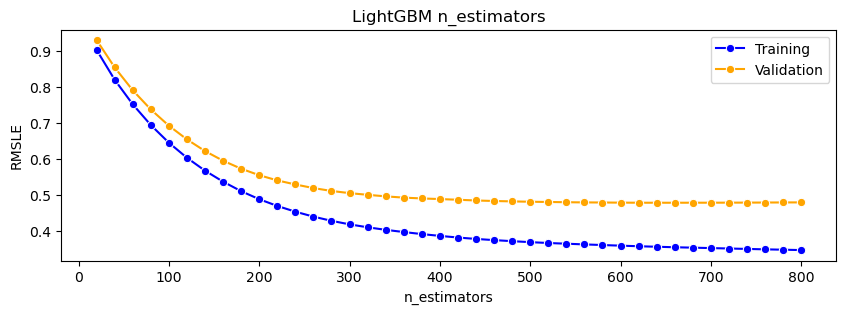

In [19]:
plt.figure(figsize = (10,3), dpi = 100)
sns.lineplot(x= n_estimators_result['n_estimators'], y= n_estimators_result['mean_rmsle_train'], marker = 'o', color = 'blue', label = 'Training')
sns.lineplot(x= n_estimators_result['n_estimators'], y= n_estimators_result['mean_rmsle_valid'], marker = 'o', color = 'orange', label = 'Validation')
plt.title('LightGBM n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('RMSLE')
plt.show()

for validation set the lowest mean **RMSLE (0.47835)** is at **n_estimators = 640**

### 2. NUM_LEAVES**

We will change the num_leaves value between (2,40) and track the RMSLE for both training and validation sets.

In [20]:
def get_num_leaves(evaluation_set, min_r, max_r):
    
    results = []
    
    for leaves in range(min_r, max_r, 2):
        x = {}
        SCORE_TRAIN = []
        SCORE_VALID = []
        
        for combo in evaluation_set:
            
            # seperate the independent and target variable from the train and validation set
            train_data_x = combo[0].drop(columns = ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
            train_data_y = combo[0]['UNITS']
            
            valid_data_x = combo[1].drop(columns = ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
            valid_data_y = combo[1]['UNITS']
            
            e_set = [(train_data_x, train_data_y), (valid_data_x, valid_data_y)]
            
            model = LGBMRegressor(n_estimators = 640,
                                    learning_rate = 0.01,
                                    n_jobs = -1,
                                    random_state = 0,
                                    num_leaves = leaves,
                                    boosting_type = 'gbdt',
                                    objective = 'regression',
                                    verbosity = -1)
            
            model.fit(train_data_x, train_data_y, eval_metric = custom_rmsle, eval_set = e_set)
            
            # store the RMSLE on train and validation sets in different lists 
            # so that at the end we can calculate the mean of results at the end 
            SCORE_TRAIN.append(model.evals_result_['training']['rmsle'][-1])
            SCORE_VALID.append(model.evals_result_['valid_1']['rmsle'][-1])
            
        mean_score_train = np.mean(SCORE_TRAIN)
        mean_score_valid = np.mean(SCORE_VALID)
            
        print('With num_leaves:\t' + str(leaves) + '\tMean_RMSLE_Train:\t' + str(mean_score_train) + '\tMean_RMSLE_Valid:\t' + str(mean_score_valid))
            
        x['num_leaves'] = leaves
        x['mean_rmsle_train'] = mean_score_train
        x['mean_rmsle_valid'] = mean_score_valid
            
        results.append(x)
        
    return pd.DataFrame(results)

In [23]:
num_leaves_result = get_num_leaves(evaluation_sets, min_r= 2, max_r=41)

With num_leaves:	2	Mean_RMSLE_Train:	0.570016633049728	Mean_RMSLE_Valid:	0.5910114341175298
With num_leaves:	4	Mean_RMSLE_Train:	0.46356942693721376	Mean_RMSLE_Valid:	0.509615754305928
With num_leaves:	6	Mean_RMSLE_Train:	0.4333677834389918	Mean_RMSLE_Valid:	0.49775450328608084
With num_leaves:	8	Mean_RMSLE_Train:	0.4136388756237984	Mean_RMSLE_Valid:	0.4866133658308189
With num_leaves:	10	Mean_RMSLE_Train:	0.40022192820381963	Mean_RMSLE_Valid:	0.4800366155743007
With num_leaves:	12	Mean_RMSLE_Train:	0.39159880871786	Mean_RMSLE_Valid:	0.4773957332662398
With num_leaves:	14	Mean_RMSLE_Train:	0.38471649534611035	Mean_RMSLE_Valid:	0.4780848236736849
With num_leaves:	16	Mean_RMSLE_Train:	0.37955968931768547	Mean_RMSLE_Valid:	0.47702528059398297
With num_leaves:	18	Mean_RMSLE_Train:	0.37527635844969276	Mean_RMSLE_Valid:	0.4766141196691924
With num_leaves:	20	Mean_RMSLE_Train:	0.3711085070410036	Mean_RMSLE_Valid:	0.47854412647861216
With num_leaves:	22	Mean_RMSLE_Train:	0.3681506786067983	Mea

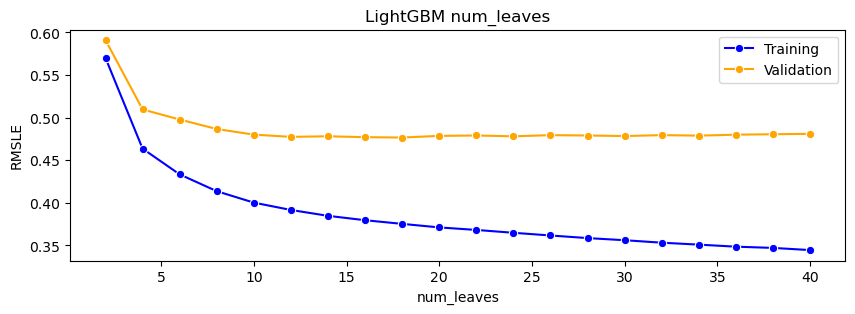

In [24]:
plt.figure(figsize = (10,3), dpi = 100)
sns.lineplot(x= num_leaves_result['num_leaves'], y= num_leaves_result['mean_rmsle_train'], marker = 'o', color = 'blue', label = 'Training')
sns.lineplot(x= num_leaves_result['num_leaves'], y= num_leaves_result['mean_rmsle_valid'], marker = 'o', color = 'orange', label = 'Validation')
plt.title('LightGBM num_leaves')
plt.xlabel('num_leaves')
plt.ylabel('RMSLE')
plt.show()

afther the **num_leaves = 16** & validation **RMSLE (0.4766)** the model is starting to over fit on the train data. So we will choose num_leaves = 16

### 3. MIN_CHILD_SAMPLES

* We will check the performance of the model for the values 1 to 5.
* The value of n_estimators will be 640 and max_depth will be 18.

In [27]:
def get_mcs(evaluation_set):
    
    results = []
    
    for mcs in range(1, 15, 1):
        x = {}
        SCORE_TRAIN = []
        SCORE_VALID = []
        
        for combo in evaluation_set:
            
            # seperate the independent and target variable from the train and validation set
            train_data_x = combo[0].drop(columns = ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
            train_data_y = combo[0]['UNITS']
            
            valid_data_x = combo[1].drop(columns = ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
            valid_data_y = combo[1]['UNITS']
            
            e_set = [(train_data_x, train_data_y), (valid_data_x, valid_data_y)]
            
            model = LGBMRegressor(n_estimators = 640,
                                    learning_rate = 0.01,
                                    n_jobs = -1,
                                    random_state = 0,
                                    min_child_samples = mcs,
                                    num_leaves = 18,
                                    boosting_type = 'gbdt',
                                    objective = 'regression',
                                    verbosity = -1)
            
            model.fit(train_data_x, train_data_y, eval_metric = custom_rmsle, eval_set = e_set)
            
            # store the RMSLE on train and validation sets in different lists 
            # so that at the end we can calculate the mean of results at the end 
            SCORE_TRAIN.append(model.evals_result_['training']['rmsle'][-1])
            SCORE_VALID.append(model.evals_result_['valid_1']['rmsle'][-1])
            
        mean_score_train = np.mean(SCORE_TRAIN)
        mean_score_valid = np.mean(SCORE_VALID)
            
        print('With min_child_samples:\t' + str(mcs) + '\tMean_RMSLE_Train:\t' + str(mean_score_train) + '\tMean_RMSLE_Valid:\t' + str(mean_score_valid))
            
        x['min_child_samples'] = mcs
        x['mean_rmsle_train'] = mean_score_train
        x['mean_rmsle_valid'] = mean_score_valid
            
        results.append(x)
        
    return pd.DataFrame(results)

In [28]:
mcs_results = get_mcs(evaluation_sets)

With min_child_samples:	1	Mean_RMSLE_Train:	0.37725078663135403	Mean_RMSLE_Valid:	0.4748582444574624
With min_child_samples:	2	Mean_RMSLE_Train:	0.3772948538215539	Mean_RMSLE_Valid:	0.47663296617505896
With min_child_samples:	3	Mean_RMSLE_Train:	0.37688404009291765	Mean_RMSLE_Valid:	0.47529190436276747
With min_child_samples:	4	Mean_RMSLE_Train:	0.3761705110373104	Mean_RMSLE_Valid:	0.47517147807866045
With min_child_samples:	5	Mean_RMSLE_Train:	0.37595437182789687	Mean_RMSLE_Valid:	0.47356293555741036
With min_child_samples:	6	Mean_RMSLE_Train:	0.37594943367181566	Mean_RMSLE_Valid:	0.4754114923399173
With min_child_samples:	7	Mean_RMSLE_Train:	0.37594302793917256	Mean_RMSLE_Valid:	0.47541518563870866
With min_child_samples:	8	Mean_RMSLE_Train:	0.3756162137729141	Mean_RMSLE_Valid:	0.47551602264138715
With min_child_samples:	9	Mean_RMSLE_Train:	0.3753457176428857	Mean_RMSLE_Valid:	0.4771917364542474
With min_child_samples:	10	Mean_RMSLE_Train:	0.3754822109741218	Mean_RMSLE_Valid:	0.47698

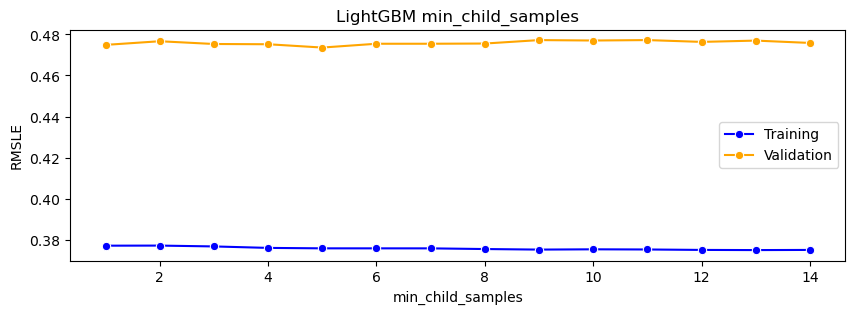

In [29]:
plt.figure(figsize = (10,3), dpi = 100)
sns.lineplot(x= mcs_results['min_child_samples'], y= mcs_results['mean_rmsle_train'], marker = 'o', color = 'blue', label = 'Training')
sns.lineplot(x= mcs_results['min_child_samples'], y= mcs_results['mean_rmsle_valid'], marker = 'o', color = 'orange', label = 'Validation')
plt.title('LightGBM min_child_samples')
plt.xlabel('min_child_samples')
plt.ylabel('RMSLE')
plt.show()

Looking at the validation RMSLE, the lowest **RMSLE(0.4735)** is at **min_child_samples = 5**

### 4. SUBSAMPLE

We will test subsample values from the list: [ 0.01, 0.05, 0.075, 0.1, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.97, 0.99, 0.999, 1]

In [30]:
def get_ss(evaluation_set):
    
    results = []
    
    for ss in [ 0.01, 0.05, 0.075, 0.1, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.97, 0.99, 0.999, 1] :
        x = {}
        SCORE_TRAIN = []
        SCORE_VALID = []
        
        for combo in evaluation_set:
            
            # seperate the independent and target variable from the train and validation set
            train_data_x = combo[0].drop(columns = ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
            train_data_y = combo[0]['UNITS']
            
            valid_data_x = combo[1].drop(columns = ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
            valid_data_y = combo[1]['UNITS']
            
            e_set = [(train_data_x, train_data_y), (valid_data_x, valid_data_y)]
            
            model = LGBMRegressor(n_estimators = 640,
                                    learning_rate = 0.01,
                                    n_jobs = -1,
                                    random_state = 0,
                                    subsample = ss,
                                    min_child_samples = 5,
                                    num_leaves = 18,
                                    boosting_type = 'gbdt',
                                    objective = 'regression',
                                    verbosity = -1)
            
            model.fit(train_data_x, train_data_y, eval_metric = custom_rmsle, eval_set = e_set)
            
            # store the RMSLE on train and validation sets in different lists 
            # so that at the end we can calculate the mean of results at the end 
            SCORE_TRAIN.append(model.evals_result_['training']['rmsle'][-1])
            SCORE_VALID.append(model.evals_result_['valid_1']['rmsle'][-1])
            
        mean_score_train = np.mean(SCORE_TRAIN)
        mean_score_valid = np.mean(SCORE_VALID)
            
        print('With subsample:\t' + str(ss) + '\tMean_RMSLE_Train:\t' + str(mean_score_train) + '\tMean_RMSLE_Valid:\t' + str(mean_score_valid))
            
        x['subsample'] = ss
        x['mean_rmsle_train'] = mean_score_train
        x['mean_rmsle_valid'] = mean_score_valid
            
        results.append(x)
        
    return pd.DataFrame(results)

In [31]:
subsample_results = get_ss(evaluation_sets)

With subsample:	0.01	Mean_RMSLE_Train:	0.37595437182789687	Mean_RMSLE_Valid:	0.47356293555741036
With subsample:	0.05	Mean_RMSLE_Train:	0.37595437182789687	Mean_RMSLE_Valid:	0.47356293555741036
With subsample:	0.075	Mean_RMSLE_Train:	0.37595437182789687	Mean_RMSLE_Valid:	0.47356293555741036
With subsample:	0.1	Mean_RMSLE_Train:	0.37595437182789687	Mean_RMSLE_Valid:	0.47356293555741036
With subsample:	0.4	Mean_RMSLE_Train:	0.37595437182789687	Mean_RMSLE_Valid:	0.47356293555741036
With subsample:	0.6	Mean_RMSLE_Train:	0.37595437182789687	Mean_RMSLE_Valid:	0.47356293555741036
With subsample:	0.7	Mean_RMSLE_Train:	0.37595437182789687	Mean_RMSLE_Valid:	0.47356293555741036
With subsample:	0.8	Mean_RMSLE_Train:	0.37595437182789687	Mean_RMSLE_Valid:	0.47356293555741036
With subsample:	0.9	Mean_RMSLE_Train:	0.37595437182789687	Mean_RMSLE_Valid:	0.47356293555741036
With subsample:	0.95	Mean_RMSLE_Train:	0.37595437182789687	Mean_RMSLE_Valid:	0.47356293555741036
With subsample:	0.97	Mean_RMSLE_Tra

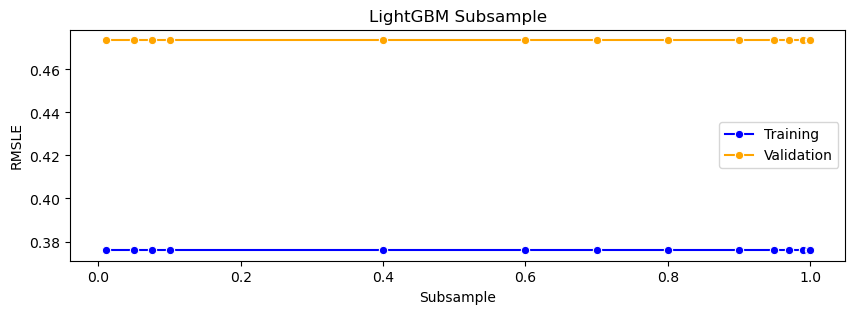

In [32]:
plt.figure(figsize = (10,3), dpi = 100)
sns.lineplot(x= subsample_results['subsample'], y= subsample_results['mean_rmsle_train'], marker = 'o', color = 'blue', label = 'Training')
sns.lineplot(x= subsample_results['subsample'], y= subsample_results['mean_rmsle_valid'], marker = 'o', color = 'orange', label = 'Validation')
plt.title('LightGBM Subsample')
plt.xlabel('Subsample')
plt.ylabel('RMSLE')
plt.show()

There's no effect of changing the subsamples over RMSLE. It's fixed at **0.4735** for all the training and validation sets. So we will keep this value as 0

## RESULT:

These are the tuned hyperparameters as per out iterations:
* **n_estimators:** 640
* **num_leaves:** 18
* **min_child_samples:** 5
* **subsample:** 0